# Data Simulation with `msprime`

This notebook introduces the `msprime` simulator, a high‑performance library for generating ancestry and mutation data under the coalescent. It supports separate ancestry and mutation simulation via the succinct tree sequence data structure. 

`msprime` is widely used in population genetics because it can simulate whole chromosomes efficiently and stores results compactly using `tskit`.

## Simulating a constant population

In this section, you can try to define some key parameters for your simulation and see the coalescent process by plotting them.

In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt

Define your own parameter settings here:

In [77]:
# # Parameters
# sequence_length = ... 
# ne = ...
# mutation_rate = ...
# recombination_rate = ...
# samples = ...  # number of diploid individuals

In [7]:
# Demography: constant population
# an example of setting up a simple demography
sequence_length = 50000
ne = 100
mutation_rate = 1e-7
recombination_rate = 1e-8
samples = 10  # number of diploid individuals

demography = msprime.Demography()
demography.add_population(initial_size=ne)

# Simulate ancestry and mutations
ts_anc = msprime.sim_ancestry(samples=samples,
                            recombination_rate=recombination_rate,
                            sequence_length=sequence_length,
                            demography=demography)

ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)
# msprime simulates the ancestry and mutations separately

print('Tree sequence has', ts.num_sites, 'segregating sites and', ts.num_trees, 'trees.')

Tree sequence has 7 segregating sites and 1 trees.


Plot the trees before and after mutations are added into the branches.

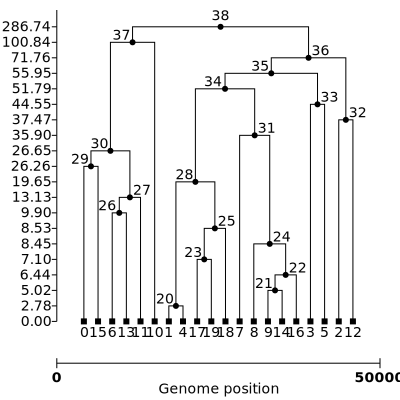

In [8]:
from IPython.display import display
svg_size = (400, 400) # Height and width for the SVG: optional but useful for this notebook
svg_string = ts_anc.draw_svg(
    size=svg_size,
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", x_scale="treewise",  # Force same axis settings as the text view
)
display(svg_string)

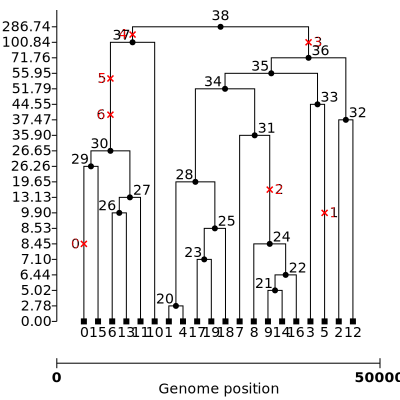

In [9]:
svg_size = (400, 400) # Height and width for the SVG: optional but useful for this notebook
svg_string = ts.draw_svg(
    size=svg_size,
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", x_scale="treewise",  # Force same axis settings as the text view
)
display(svg_string)

The simulation generates a tree sequence `ts`, which is essentially a record of how all sampled individuals coalesce back to their common ancestors. 

By placing mutations along the branches of these ancestral trees (according to the specified mutation rate), `msprime` outputs simulated genetic variation—ultimately yielding SNP data or variant matrices that can be used for downstream analyses, such as training neural posterior estimators in our pipeline. 

### Let us check the SNP matrix from the tree sequence.

> A quick reminder: the SNP matrix can be seen as the simulated data x, and the parameters used for simulation are the $\theta$.

In [11]:
genotypes = ts.genotype_matrix()  # Shape: (n_variants, n_samples)
print('Genotype matrix shape:', genotypes.shape)

Genotype matrix shape: (7, 20)


This is one type of data we can use as the input for our parameter inference later.

Now there are multiple ways how to make this high-dimensional data accessible for the neural posterior estimation network. 

We need to provide features to the NPE network. These features can be predefined **summary statistics** based on SNP matrix or can be extracted by a neural embedding network. 

An embedding network can either be pretrained or trained jointly with the NPE network in an end-to-end manner. However, in this workshop, we will stick with using predefined summary statistics.

## Summary statistics: allele frequency spectrum (AFS)
AFS counts how many mutations appear in exactly k haploids. We can use the `tskit` package to extract the AFS directly.

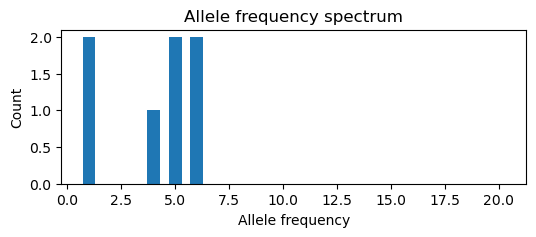

In [24]:
# Compute and plot the folded SFS
sfs = ts.allele_frequency_spectrum(span_normalise=False)
freqs = np.arange(1, len(sfs))

plt.figure(figsize=(6, 2))
plt.bar(freqs, sfs[1:], width=0.6)
plt.xlabel('Allele frequency')
plt.ylabel('Count')
plt.title('Allele frequency spectrum')
plt.show()

With AFS, we now have a pair of theta and x (the population parameters, and AFS from its SNP matrix) for NPE.

> AFS reflects the evolutionary history of the population. Changing the parameters, we can see how the AFS changes.

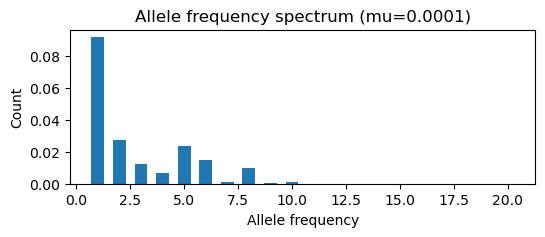

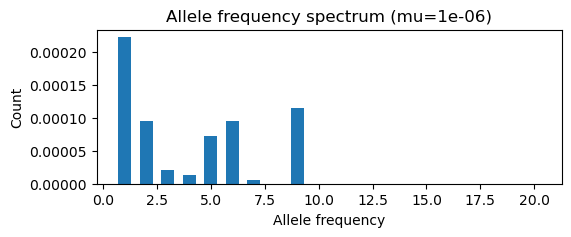

In [31]:
sequence_length = 1e6
mutation_rate = [1e-4, 1e-6]

for mu in mutation_rate:
    demography = msprime.Demography()
    demography.add_population(initial_size=ne)

    ts_anc = msprime.sim_ancestry(samples=samples,
                                recombination_rate=recombination_rate,
                                sequence_length=sequence_length,
                                demography=demography)

    ts = msprime.sim_mutations(ts_anc, rate=mu)
    sfs = ts.allele_frequency_spectrum()
    freqs = np.arange(1, len(sfs))

    plt.figure(figsize=(6, 2))
    plt.bar(freqs, sfs[1:], width=0.6)
    plt.xlabel('Allele frequency')
    plt.ylabel('Count')
    plt.title(f'Allele frequency spectrum (mu={mu})')
    plt.show()

Since AFS, as a type of summary statistics, is corelated with the population parameters. We can use AFS along with the parameter for training neural posterior estimator. Therefore, we can infer the hidden population parameters based on observed genetic data.